# ToDo

- [x] Dataset download script
- [x] Basic model
- [x] Test/train split
- [x] F1 score analysis
- [x] Document loss in training and plot training loss
  

# GPU


In [ ]:
!nvidia-smi

Tue Apr  5 17:15:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    36W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Dataset download

Dataset taken from https://advnet.seas.upenn.edu/

In [1]:
!gdown --id 13NdhIvPgzOQoRg9A-xUUXSsfxVwPrEUV

Downloading...
From: https://drive.google.com/uc?id=13NdhIvPgzOQoRg9A-xUUXSsfxVwPrEUV
To: /content/LisaCnn.zip
100% 6.47M/6.47M [00:00<00:00, 41.2MB/s]


In [2]:
!unzip -q LisaCnn.zip 

# Script

In [3]:
import torch
import glob
import os
import PIL
import torchvision
import numpy as np
from torch.utils.data import random_split

class AdvSignDataset(torch.utils.data.Dataset):
  def __init__(self, path):
    import sklearn.preprocessing
    super().__init__()
    assert path is not None
    self.image_paths = glob.glob(os.path.join(path, "**", "**", "*.jpg"))
    self.data = []

    # self.encoder = sklearn.preprocessing.OneHotEncoder()
    # classes = [p.split("/")[-3] for p in self.image_paths]
    # classes = np.reshape(classes, (-1,1))
    # self.encoder.fit(classes)
    # self.y_sign_types = self.encoder.transform(classes).toarray()
    
    print(f"Found {len(self.image_paths)} images")

  def __getitem__(self, index):
    path = self.image_paths[index]
    isClean = "Clean" in path.split("/")[-2]
    with PIL.Image.open(path) as image:
      return {
          "path": path,
          "type": path.split("/")[-3],
          "isClean": isClean,
          "x": torchvision.transforms.ToTensor()(image),
          "y": torch.tensor([1,0] if isClean else [0,1], dtype=float)
      }
  
  def __len__(self):
    return len(self.image_paths)

In [8]:
class AdvSignModel(torch.nn.Module):
  def __init__(self) -> None:
    super(AdvSignModel, self).__init__()

    self.layers = torch.nn.Sequential(
      torch.nn.Conv2d(in_channels=3, out_channels=512, kernel_size=5, padding="same"),
      torch.nn.Sigmoid(),
      torch.nn.Flatten(),
      torch.nn.BatchNorm1d(num_features=512*32*32),
      torch.nn.Linear(in_features=32*32*512, out_features=2)
    )
  
  def forward(self, x):
    return self.layers(x)

In [23]:
# Slightly modified implementation of the Lisa CNN model used in cleverhans
# https://github.com/evtimovi/robust_physical_perturbations/blob/master/lisa-cnn-attack/cleverhans/utils_keras.py
class LisaModel(torch.nn.Module):
  def __init__(self) -> None:
    super(LisaModel, self).__init__()

    self.layers = torch.nn.Sequential(
      # 2D Convolutional layer with 64 filters
      torch.nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(8, 8), stride=(2, 2)),
      # ReLU activation layer
      torch.nn.ReLU(),
      # Double the number of filters to extract even more features from the images
      torch.nn.Conv2d(in_channels=64, out_channels=2*64, kernel_size=(6, 6), stride=(2, 2), padding="valid"),
      torch.nn.ReLU(),
      torch.nn.Conv2d(in_channels=2*64, out_channels=2*64, kernel_size=(3, 3), stride=(1, 1), padding="valid"),
      torch.nn.ReLU(),
      # Flatten for the output layer
      torch.nn.Flatten(),
      torch.nn.Linear(in_features=512, out_features=2)
    )
  
  def forward(self, x):
    return self.layers(x)

In [75]:
class Trainer:
  def __init__(self, model=None, device=None, lr=0.001):
    if model is None: model = AdvSignModel()
    if device is None: device = torch.device("cuda")
    self.device = device
    self.model = model.to(device)
    self.loss_func=torch.nn.CrossEntropyLoss()
    self.model_optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  
  def train_step(self, x, y):
    y_pred = self.model(x)
    # print(y_pred)
    # https://discuss.pytorch.org/t/categorical-cross-entropy-loss-function-equivalent-in-pytorch/85165/4
    loss = self.loss_func(y_pred, y)
    self.model_optimizer.zero_grad()
    loss.backward()
    self.model_optimizer.step()
    return loss

  def train(
    self,
    epochs=10,
    dataset=None,
    batch_size=256
  ):
    import tqdm.notebook
    if dataset is None: dataset = AdvSignDataset("LisaCnn")
    
    self.dataloader = torch.utils.data.DataLoader(
      dataset,
      batch_size=batch_size,
      shuffle=True,
      num_workers=0
    )
    lossHistory = []
    for epoch in tqdm.notebook.tqdm(range(0, epochs), total=epochs):
      for i,v in tqdm.notebook.tqdm(enumerate(self.dataloader), total=len(self.dataloader)):
        x = v["x"].to(self.device)
        y = v["y"].to(self.device)
        # if len(x) != self.dataloader.batch_size: break
        loss = self.train_step(x, y)
        lossHistory.append(loss)
    return lossHistory

In [65]:
dataset = AdvSignDataset("LisaCnn")
trainData, testData = torch.utils.data.random_split(dataset, [int(0.7*len(dataset)), len(dataset)-int(0.7*len(dataset))])
print(len(dataset), len(trainData), len(testData))

Found 4666 images
4666 3266 1400


In [82]:
# trainer = Trainer(model=LisaModel())
trainer = Trainer()
loss = trainer.train(dataset=trainData)
pass

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

In [83]:
lossCpu = [x.cpu().detach().numpy() for x in loss]

In [84]:
len(trainData)/256

12.7578125

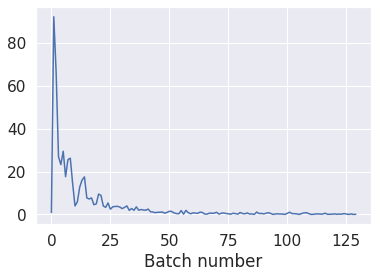

In [85]:
import matplotlib.pyplot as plt
plt.plot(lossCpu)
plt.xlabel("Batch number")
plt.show()

In [86]:
pred = []
actual = []
dataloader = torch.utils.data.DataLoader(
  dataset,
  batch_size=64,
  shuffle=True,
  num_workers=0
)
import tqdm.notebook
for i,v in tqdm.notebook.tqdm(enumerate(dataloader), total=len(dataloader)):
  x = v["x"].to(trainer.device)
  y_pred=trainer.model(x).cpu().detach().numpy()
  y_pred_flat = y_pred.argmax(1)
  y_flat = v["y"].numpy().argmax(-1)
  pred = np.concatenate([pred, y_pred_flat])
  actual = np.concatenate([actual, y_flat])


  0%|          | 0/73 [00:00<?, ?it/s]

In [87]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
import sklearn.metrics
f1 = sklearn.metrics.f1_score(actual, pred)
confusion = sklearn.metrics.confusion_matrix(actual, pred)

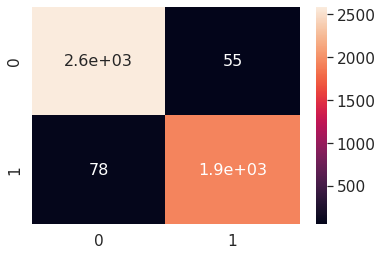

In [88]:
import seaborn as sn
sn.set(font_scale=1.4)
sn.heatmap(confusion, annot=True, annot_kws={"size":16})
plt.show()

In [89]:
print(f1)

0.966923650833126


In [ ]:
# Create a trainer instance with the Lisa CNN as a model
lisa_trainer = Trainer(model=LisaModel())
# train the Lisa CNN
lisa_trainer.train(epochs=5, batch_size=16)

batch size of 4

## unused below

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adadelta, Adam, Nadam
from tensorflow.keras.metrics import Recall, Precision, TrueNegatives, TruePositives, FalseNegatives, FalsePositives
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import f1_score

# Function for building our model, fitting the data
# In: Training and validation data
# Out: history object
def model_2d_data(x_tr, x_val, y_tr, y_val):
    # The input layer, sets the shape of a batch according to the 
    #   dimensions of the image
    in_layer = Input(batch_shape=(None, x_tr[0].shape[0], x_tr[0].shape[1], x_tr[0].shape[2]))
    # Convolutional layer with 32 filters, kernel size (3, 3), and ReLu as an
    #   activation function
    c1 = Conv2D(32, (3, 3), activation='relu')(in_layer)
    # Batch Normalization layer
    b1 = BatchNormalization()(c1)
    # Max Pooling Layer with a (2, 2) pool size
    m1 = MaxPooling2D(pool_size=(2, 2))(b1)
    c2 = Conv2D(64, (3, 3), activation='relu')(m1)
    b2 = BatchNormalization()(c2)
    m2 = MaxPooling2D(pool_size=(2, 2))(b2)
    c3 = Conv2D(64, (3, 3), activation='relu')(m2)
    m3 = MaxPooling2D(pool_size=(2, 2))(c3)
    # Flattening layer before moving to the fully connected layers
    f1 = Flatten()(m3)
    # Fully connected hidden layer with 2048 nodes
    d1 = Dense(2048, activation='relu')(f1)
    # Dropout layer
    drop1 = Dropout(0.5)(d1)
    d2 = Dense(2048, activation='relu')(drop1)
    drop2 = Dropout(0.5)(d2)
    # This model was made for a binary classification task so the output layer
    #   is only one value with the sigmoid activation function, we will use 
    #   a three node output layer with softmax instead
    d3 = Dense(1, activation='sigmoid')(drop2)

    # Sets up the model
    model = Model(inputs= in_layer, outputs= d3)

    # Creates the model
    model.compile(
        # Pretty good optimizer, same as Adam but uses Nesterov momentum
        optimizer= Nadam(learning_rate=1e-8),
        # Binary loss function
        loss= 'binary_crossentropy',
        # Not necessary to have all these metrics
        metrics= ['accuracy', 'AUC', Recall(), Precision(), TrueNegatives(), TruePositives(), FalseNegatives(), FalsePositives()]
    )

    model.summary()

    # Fits the model and creates a history object that consists of all the 
    #   training metrics, including performance on the validation set
    history = model.fit(x_tr,
                        y_tr,
                        # How many times to go through the dataset
                        epochs=10,
                        # How many images to train on in each iteration
                        batch_size=16,
                        validation_data=(x_val, y_val),
                        verbose=1)
    return history